# Tutorial 0 - Introduction

In this tutorial, we will study different approaches for binary digit classification (two classes). We first explore a naive classification approach based on counting the number of "white" pixels. We then use a logistic regression where every pixel is a feature. Finally, we test a logistic regression using a small set of derived imaging features.

**Objective:** Observe differences between three different classification approaches

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

/tmp/ipykernel_12565/3248899114.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data

In [2]:
# ! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/morpho-mnist.zip
# ! unzip morpho-mnist.zip

In [3]:
data_dir = './data'
train_set = MNIST(data_dir, train=True, download=True)
test_set = MNIST(data_dir, train=False, download=True)
print(train_set.data.shape)
print(test_set.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [4]:
def plot_digits(data, n_samples_row=10, colormap = matplotlib.cm.gray, clim=None):
    images = [image.reshape(28,28) for image in data]
    n_rows = (len(images) - 1) // n_samples_row + 1
    # append empty images if the last row is not complete
    empty_images = n_rows * n_samples_row - len(data)
    images.append(np.zeros((28, 28 * empty_images)))
    # draw row by row
    images_row = []
    for current_row in range(n_rows):
        tmp_row_images = images[current_row * n_samples_row : (current_row + 1) * n_samples_row]
        images_row.append(np.concatenate(tmp_row_images, axis=1))
    # draw all in one image
    image = np.concatenate(images_row, axis=0)
    plt.figure(figsize=(n_samples_row,n_rows))
    plt.imshow(image, cmap = colormap, clim=clim)
    plt.colorbar()
    plt.axis("off")

Let's plot some random examples from the MNIST dataset

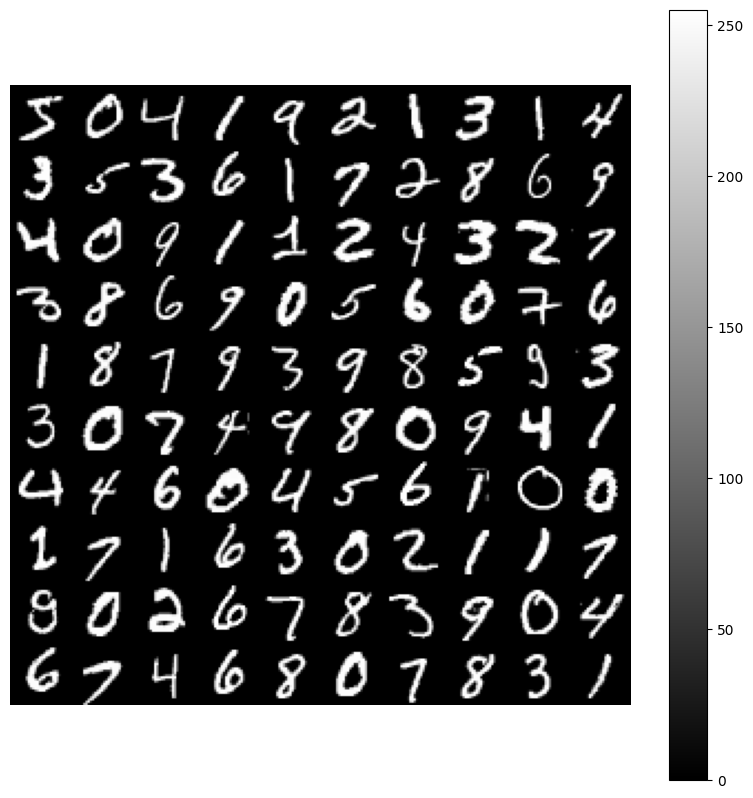

In [5]:
plot_digits(train_set.data[:100])
plt.show()

## Experiments

**Task:** Change the selected digits to [0,8] and other combinations, and observe the effect on the classification approaches.

In [6]:
selected_digits = [1,7]

# Keep only the digits in `selected_digits` in the TRAINING data
selected_indexes = np.isin(train_set.targets, selected_digits)
train_data = np.array(train_set.data[selected_indexes]).astype(np.float32) / 255.0
train_labels = np.array(train_set.targets[selected_indexes] == selected_digits[1])

# Keep only the digits in `selected_digits` in the TESTING data
selected_indexes = np.isin(test_set.targets, selected_digits)
test_data = np.array(test_set.data[selected_indexes]).astype(np.float32) / 255.0
test_labels = np.array(test_set.targets[selected_indexes] == selected_digits[1])

nsamples, nx, ny = train_data.shape
train_data = np.reshape(train_data,(nsamples,nx*ny))

nsamples, nx, ny = test_data.shape
test_data = np.reshape(test_data,(nsamples,nx*ny)).astype(np.float32)

Let's plot some random examples from the training set with selected digit classes

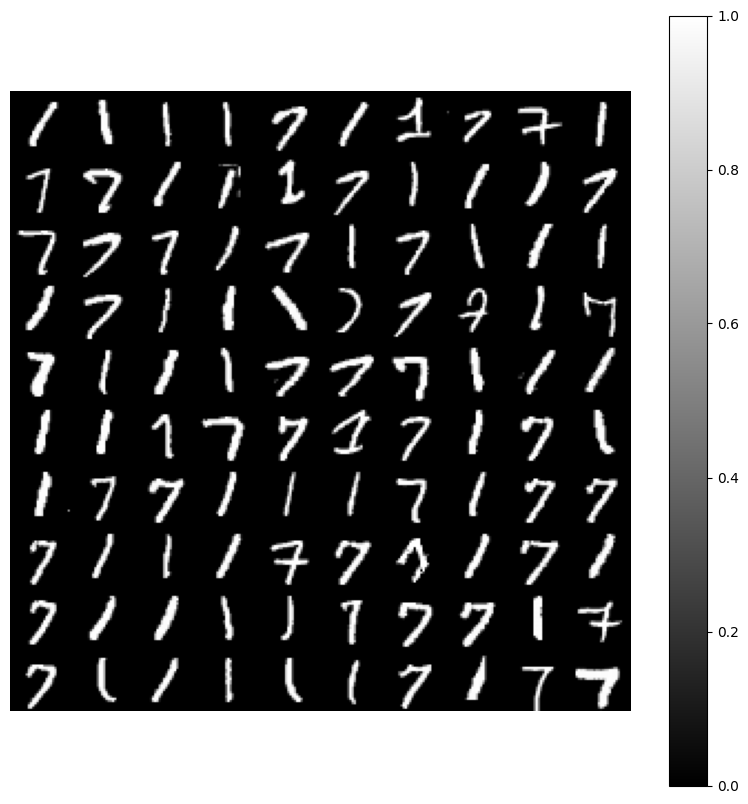

In [7]:
plot_digits(train_data[:100])
plt.show()

### Approach 1: Classification via naive thresholding on hand-crafted feature

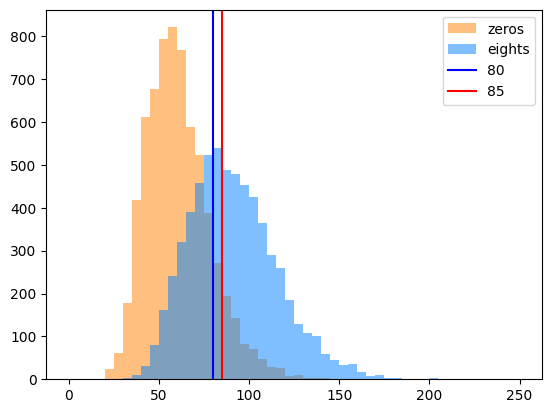

In [8]:
sum_digit_0 = np.sum(train_data[train_labels==0]>0.5, axis=1)
sum_digit_1 = np.sum(train_data[train_labels==1]>0.5, axis=1)

plt.hist(sum_digit_0, bins=50, range=(0.0, 250.0), fc=[1,0.5,0,0.5], label='zeros')
plt.hist(sum_digit_1, bins=50, range=(0.0, 250.0), fc=[0,0.5,1,0.5], label='eights')
plt.axvline(x=80, color='b', linestyle='-', label='80')
plt.axvline(x=85, color='r', linestyle='-', label='85')
plt.legend()
plt.show()

Based on the histogram, let's choose a sensible threshold that separates the two classes

In [9]:
threshold = 85
sum_digit_pixels = np.sum(train_data>0.5, axis=1) # for each digit, returns the number of pixels that are greater than 0.5
train_predictions = sum_digit_pixels >= threshold # returns all those samples which are greater than the threshold line

sum_digit_pixels = np.sum(test_data>0.5, axis=1) # similarly to above
test_predictions = sum_digit_pixels >= threshold # similarly to above

Calculate and report the classification accuracy

In [10]:
train_acc = 100.0 * (train_predictions == train_labels).mean()
print('Train accuracy = {:.2f}%'.format(train_acc))

test_acc = 100.0 * (test_predictions == test_labels).mean()
print('Test accuracy = {:.2f}%'.format(test_acc))

Train accuracy = 74.01%
Test accuracy = 74.20%


### Approach 2: Logistic regression using all pixels as features

Let's use a logistic regression model from the scikit-learn library

In [11]:
model = linear_model.LogisticRegression(C=.0001, solver='liblinear')
model.fit(train_data, train_labels)

LogisticRegression(C=0.0001, solver='liblinear')

Calculate and report the classification accuracy

In [12]:
train_preds = model.predict(train_data)
logistic_train_acc = 100.0 * (train_preds == train_labels).mean()
print('Train accuracy = {:.2f}%'.format(logistic_train_acc))

test_preds = model.predict(test_data)
logistic_test_acc = 100.0 * (test_preds == test_labels).mean()
print('Test accuracy = {:.2f}%'.format(logistic_test_acc))

Train accuracy = 97.70%
Test accuracy = 97.09%


Let's inspect the learned pattern

weights of coefficients we get. What do the weights mean? It is a mask/template that you put over an mnist digit; it is a learnt template, a discriminative model that pushes the two classes appart

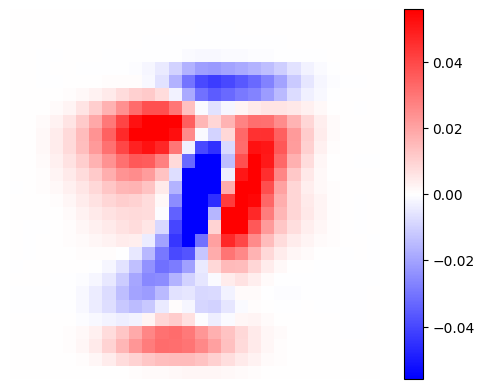

In [13]:
vmax = np.max(np.abs(model.coef_)) / 2
plt.imshow(model.coef_.reshape(28,28), cmap=matplotlib.cm.bwr, clim=(-vmax,vmax))
plt.colorbar()
plt.axis('off')
plt.show()

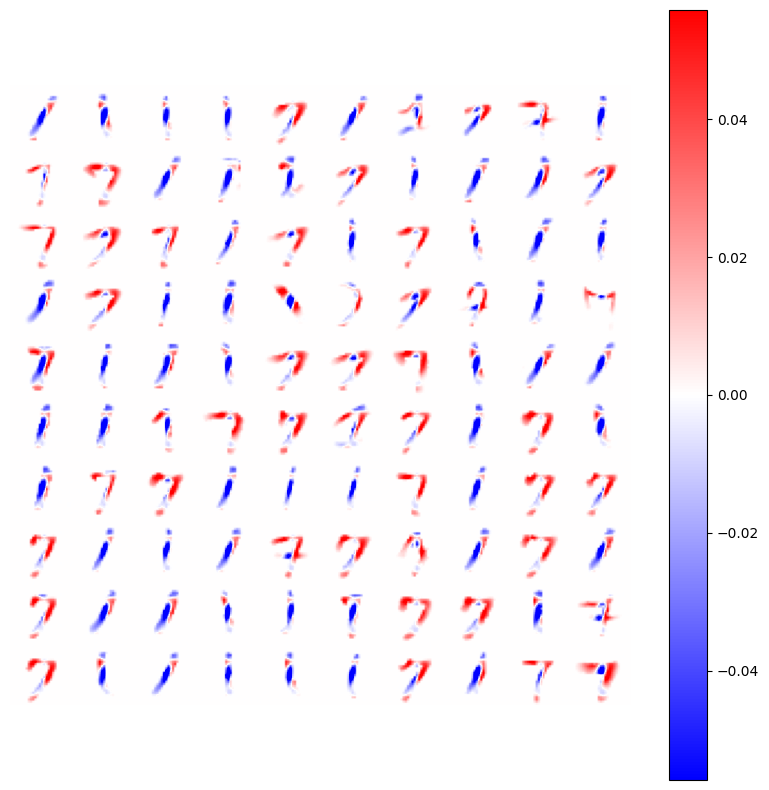

In [14]:
pattern = np.tile(model.coef_, (100, 1))
plot_digits(np.multiply(train_data[:100],pattern), colormap=matplotlib.cm.bwr, clim=(-vmax,vmax))
plt.show()

### Approach 3: Logistic regression using image-derived features

We load the Morpho-MNIST dataset which contains pre-computed, image-derived features for MNIST digits

In [15]:
train_set2 = pd.read_csv(data_dir + '/MNIST/train-morpho.csv')
train_set2['class label'] = train_set.targets
test_set2 = pd.read_csv(data_dir + '/MNIST/t10k-morpho.csv')
test_set2['class label'] = test_set.targets

train_set2.head() # show the first five data entries of the training set

,index,area,length,thickness,slant,width,height,class label
0,0,107.3125,50.266504,2.460658,0.231074,14.539572,19.849054,5
1,1,123.2500,51.198485,2.616601,0.331858,15.387810,19.341053,0
2,2,78.3750,45.927670,1.891592,-0.212196,20.479656,19.114880,4
3,3,67.3125,22.849242,2.919769,0.509185,5.358179,19.724599,1
4,4,91.1875,46.284271,2.247425,0.007590,13.275437,19.527523,9


Let's inspect the feature separation across all digit classes for a random sample with 1,000 digits and two of the features. Feel free to try it out with other feature combinations.

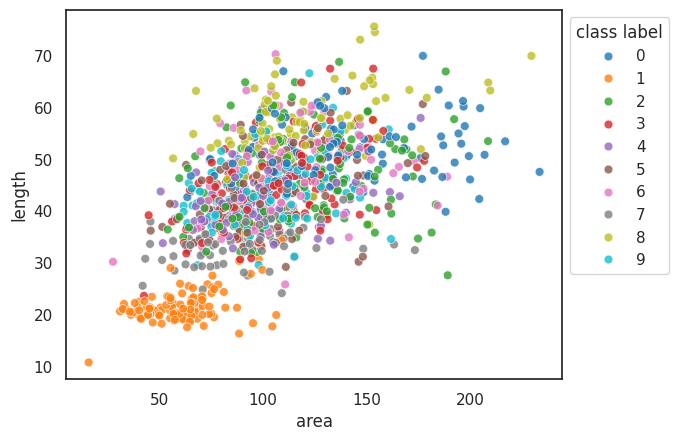

In [16]:
sns.set_theme(style="white")
ax = sns.scatterplot(data=test_set2.sample(n=1000), x='area', y='length', hue='class label', alpha=0.8, marker='o', s=40, palette='tab10')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [17]:
# Reformat the data
train_data2_all = np.transpose(np.array([train_set2['area'].values,train_set2['length'].values,train_set2['thickness'].values,train_set2['slant'].values,train_set2['width'].values,train_set2['height'].values]))
test_data2_all = np.transpose(np.array([test_set2['area'].values,test_set2['length'].values,test_set2['thickness'].values,test_set2['slant'].values,test_set2['width'].values,test_set2['height'].values]))

In [18]:
selected_indexes = np.isin(train_set.targets, selected_digits)
train_data2 = np.array(train_data2_all[selected_indexes]).astype(np.float32)
train_labels2 = np.array(train_set.targets[selected_indexes] == selected_digits[1])

selected_indexes = np.isin(test_set.targets, selected_digits)
test_data2 = np.array(test_data2_all[selected_indexes]).astype(np.float32)
test_labels2 = np.array(test_set.targets[selected_indexes] == selected_digits[1])

We normalise the features using feature scaling before feeding into the logistic regression

In [19]:
pipe = make_pipeline(StandardScaler(), linear_model.LogisticRegression(C=.0001, solver='liblinear'))
pipe.fit(train_data2, train_labels2)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, solver='liblinear'))])

Calculate and report the classification accuracy

In [20]:
train_preds2 = pipe.predict(train_data2)
logistic_train_acc2 = 100.0 * (train_preds2 == train_labels2).mean()
print('Train accuracy = {:.2f}%'.format(logistic_train_acc2))

test_preds2 = pipe.predict(test_data2)
logistic_test_acc2 = 100.0 * (test_preds2 == test_labels2).mean()
print('Test accuracy = {:.2f}%'.format(logistic_test_acc2))

Train accuracy = 96.08%
Test accuracy = 96.53%
